# 데이터 전처리

In [1]:
import os
root_dir = '../../' if os.getcwd().split('/')[-1] != 'customer' else './'
os.chdir(root_dir)

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date

from sklearn import model_selection
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
train = pd.read_csv('original_data/train.csv')
test = pd.read_csv('original_data/test.csv')
print(train.columns.tolist())
train.head()

['id', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response', 'target']


,id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,NumDealsPurchases,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,target
0,0,1974,Master,Together,46014.0,1,1,21-01-2013,21,10,...,8,7,0,0,0,0,0,0,0,541
1,1,1962,Graduation,Single,76624.0,0,1,24-05-2014,68,1,...,7,1,1,0,0,0,0,0,0,899
2,2,1951,Graduation,Married,75903.0,0,1,08-04-2013,50,2,...,9,3,0,0,0,0,0,0,0,901
3,3,1974,Basic,Married,18393.0,1,0,29-03-2014,2,2,...,3,8,0,0,0,0,0,0,0,50
4,4,1946,PhD,Together,64014.0,2,1,10-06-2014,56,7,...,5,7,0,0,0,1,0,0,0,444


### Label Encoding
문자열 feature인 Education과 Martial_Status를 정수형으로 변환합니다.   
Martial_Status의 'Alone', 'YOLO', 'Absurd' 데이터는 앞선 EDA 과정에서 'Single' 범주로 통합하기로 판단했습니다.

In [3]:
single_list = ['Alone','YOLO','Absurd']
train['Marital_Status'] = train['Marital_Status'].apply(lambda x: 'Single' if x in single_list else x)
test['Marital_Status'] = test['Marital_Status'].apply(lambda x: 'Single' if x in single_list else x)

label_features = ['Education','Marital_Status']
for feature in label_features:
    label_encoder = LabelEncoder()
    train[feature] = label_encoder.fit_transform(train[feature])
    test[feature] = label_encoder.transform(test[feature])

### Derived Variables
최대한 다양한 특징을 보이기 위해 파생 변수를 생성했습니다.
- `Age`: 2022년 기준 고객의 나이
- `Age_Range`: 고객 나이 구간 (30대부터 70대 사이, 20대와 80대는 가까운 범위와 병합)
- `Days_Customer`: 2022년 1월 1일 기준 고객이 회사에 가입한 일수
- `Income_Level`: 고객 나이 구간 별 소득 수준
- `Income_Per`: 고객 연간 개인 소득
- `NumPurchases`: 고객의 총 구매 횟수
- `Perferred_Purchase`: 고객이 선호하는 구매 방식
- `NumAcceptedCmp`: 고객이 캠페인에서 제안을 수락한 횟수

In [5]:
for df in [train,test]:
    df['Age'] = 2022-df['Year_Birth']
    df['Age_Range'] = (df['Age']//10).replace({2:3,8:7})

    df['Dt_Customer'] = df['Dt_Customer'].apply(lambda x: list(map(int,x.split('-'))))
    df['Dt_Customer'] = df['Dt_Customer'].apply(lambda x: date(x[2],x[1],x[0]))
    df['Days_Customer'] = df['Dt_Customer'].apply(lambda x: (date(2022,1,1)-x).days)

    max_income = df[['Age_Range','Income']].groupby('Age_Range').max()
    df['Income_Level'] = [row['Income']/max_income.loc[row['Age_Range']][0] for _,row in df.iterrows()]
    df['Income_Per'] = df['Income']/(df['Kidhome']+1)

    purchase_list = [f'Num{cat}Purchases' for cat in['Web','Catalog','Store']]
    df['NumPurchases'] = [sum(row) for _,row in df[purchase_list].iterrows()]
    purchase_dict = {cat: i for i, cat in enumerate(purchase_list)}
    df['Perferred_Purchase'] = [purchase_dict[row.index[row.argmax()]] for _,row in df[purchase_list].iterrows()]

    campains = [f'AcceptedCmp{i}' for i in range(1,6)]+['Response']
    df['NumAcceptedCmp'] = sum([df[campain] for campain in campains])

### Remove Outliers
이상치로 여겨지는 행들을 제거합니다.

In [7]:
columns = ['Year_Birth','Income']
for column, outlier in zip(columns,[0,2]):
    cutted_data = pd.cut(train[column],bins=3,labels=[0,1,2])
    train = train[cutted_data != outlier]

In [8]:
[df.drop(['id','Year_Birth','Dt_Customer'], axis=1, inplace=True) for df in [train,test]]

print(train.shape)
train.head()

(1102, 27)


,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,...,Response,target,Age,Age_Range,Days_Customer,Income_Level,Income_Per,NumPurchases,Perferred_Purchase,NumAcceptedCmp
0,3,3,46014.0,1,1,21,10,7,1,8,...,0,541,48,4,3267,0.283343,23007.0,16,2,0
1,2,2,76624.0,0,1,68,1,5,10,7,...,0,899,60,6,2779,0.775727,76624.0,22,1,1
2,2,1,75903.0,0,1,50,2,6,6,9,...,0,901,71,7,3190,0.667373,75903.0,21,2,0
3,1,1,18393.0,1,0,2,2,3,0,3,...,0,50,48,4,2835,0.113259,9196.5,6,0,0
4,4,3,64014.0,2,1,56,7,8,2,5,...,0,444,76,7,2762,0.562840,21338.0,15,0,1


이상치 제거 후 train 데이터는 기존 1108 행에서 6개 행이 제거되어 1102 행으로 감소했습니다.   
전처리 후 불필요한 'id', 'Year_Birth', 'Dt_Customer' 열은 제거합니다.

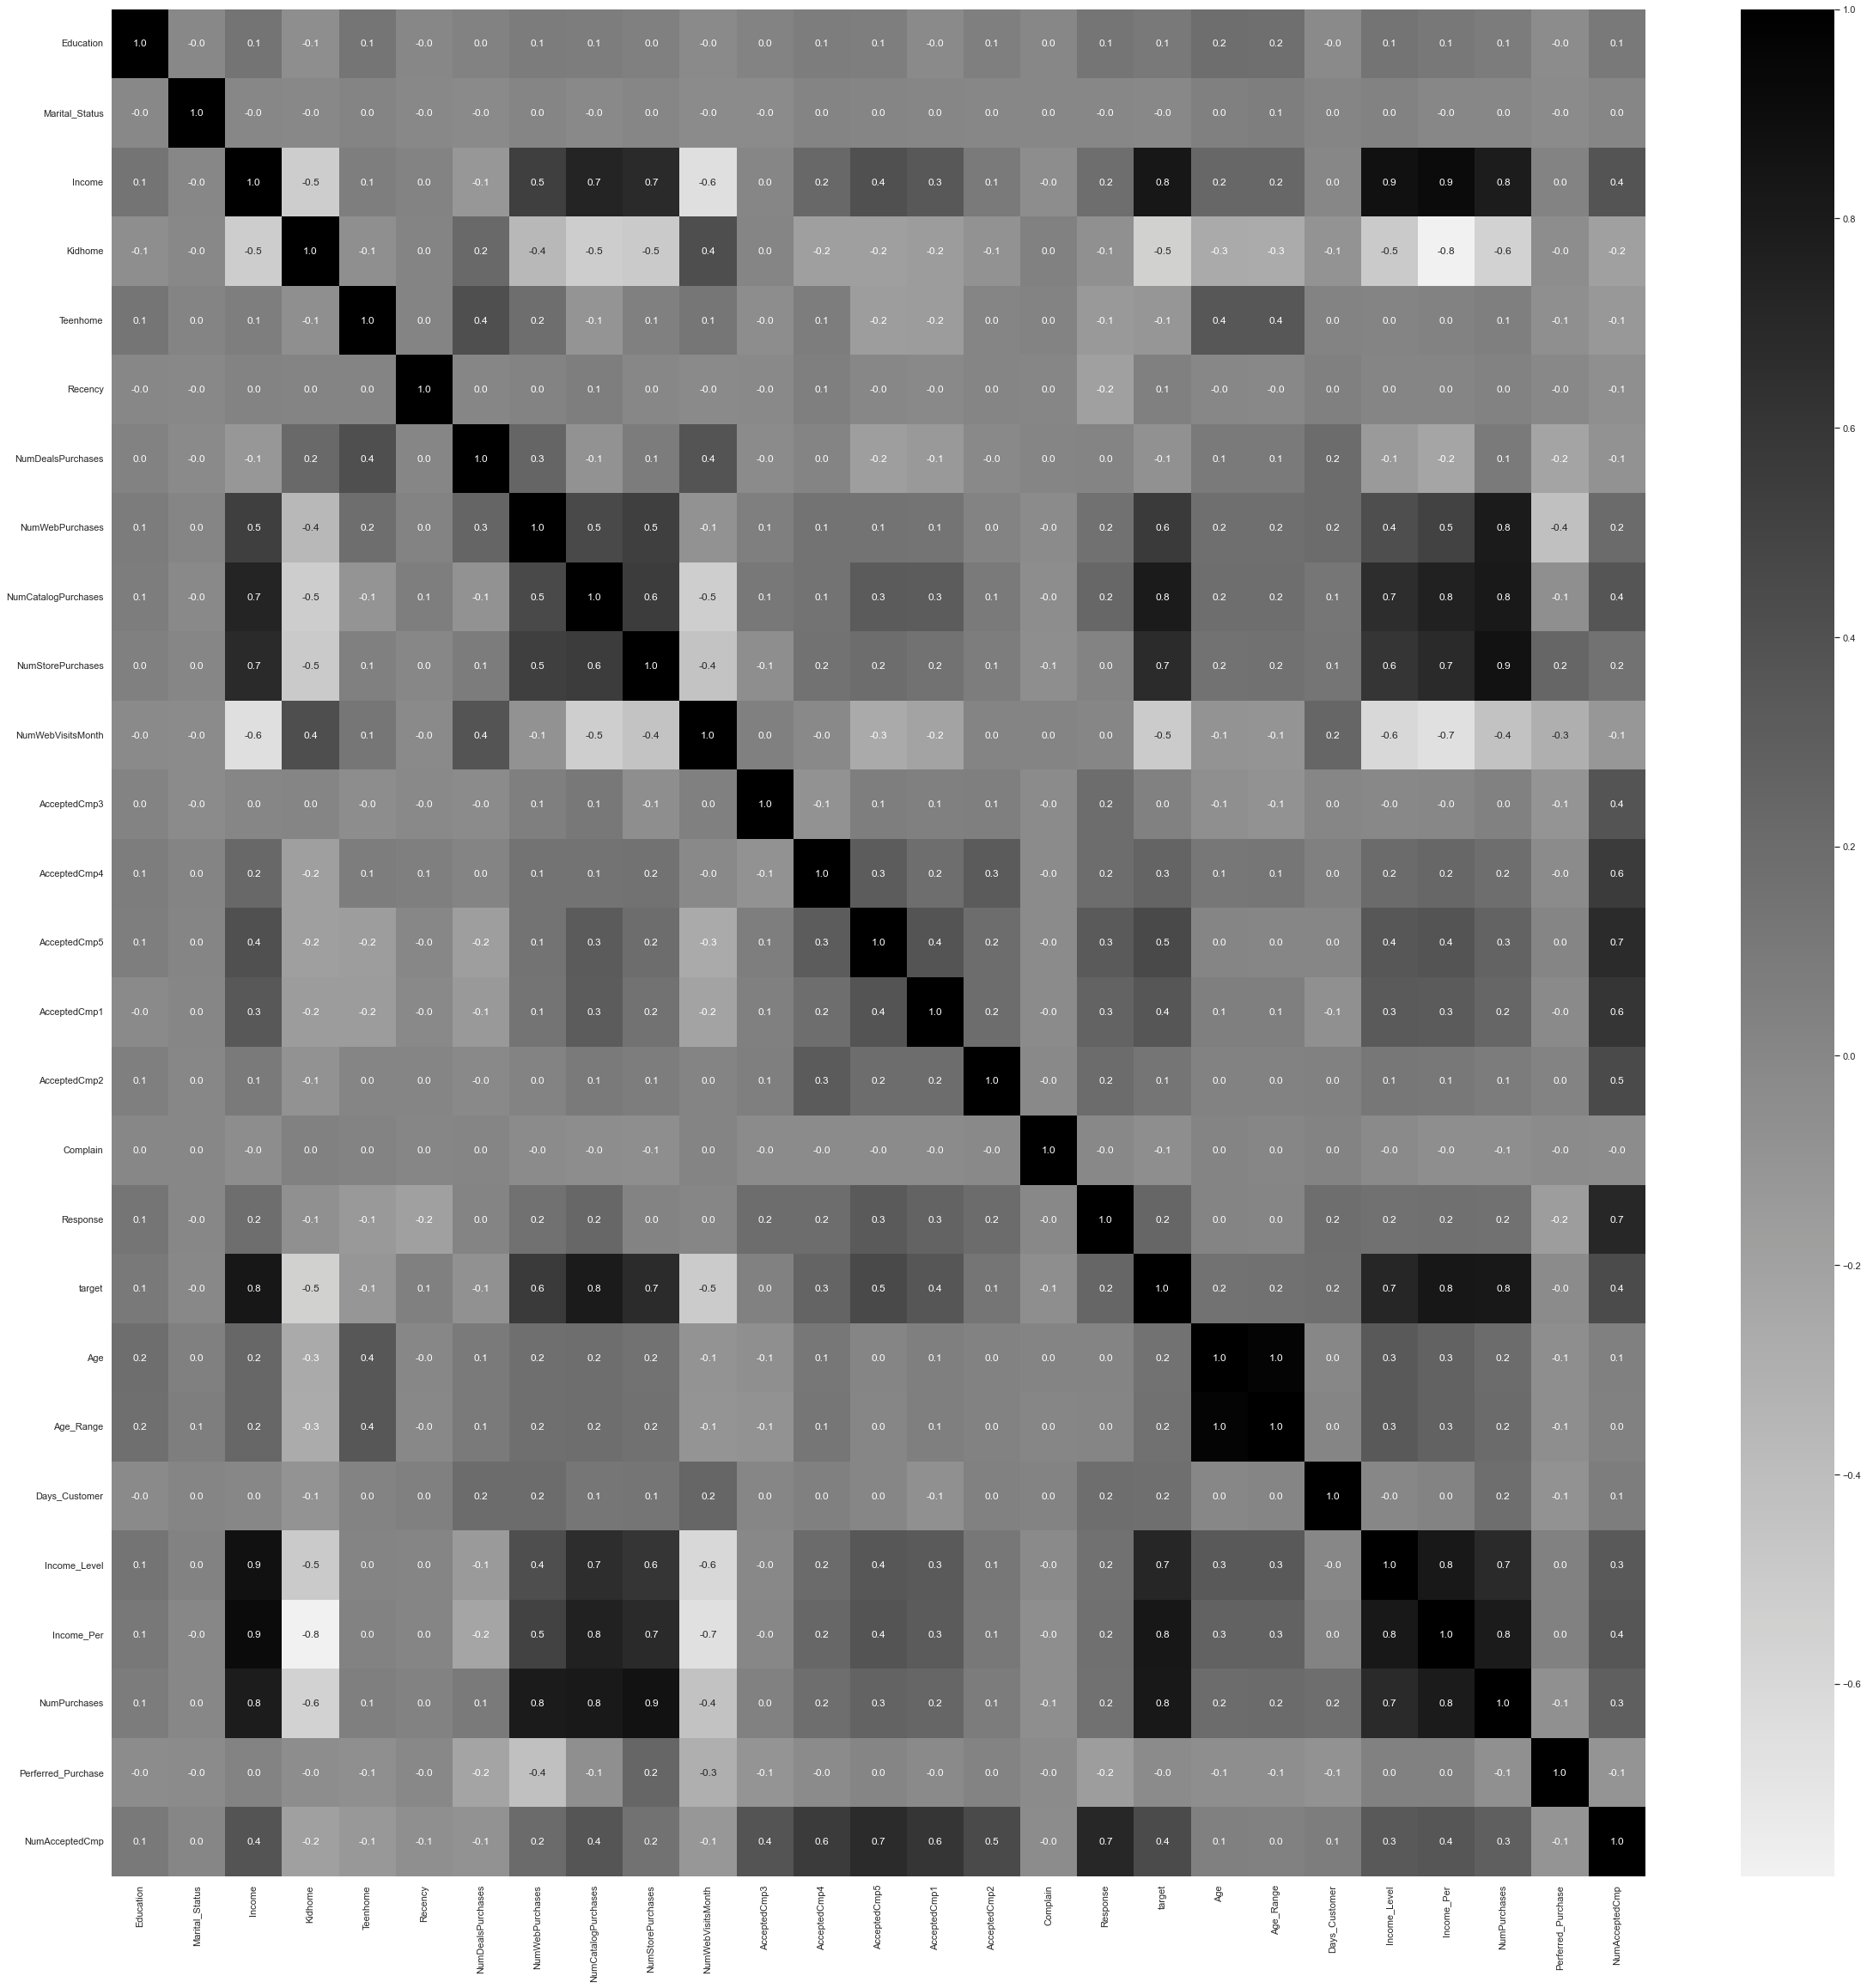

In [9]:
plt.figure(figsize=(40,40))
sns.set(style='whitegrid')
cmap = sns.light_palette("black", as_cmap=True)
sns.heatmap(train.corr(), annot=True, fmt='3.1f', cmap=cmap)
plt.show()

각 열들 간의 상관관계를 그려보았습니다.   
파생 변수들 중 일부가 기존 변수와 다중공선성을 보이는 것을 확인했지만,   
해당 변수들을 제거하는 것보다 남기는 것이 성능이 더 좋았고 다양한 경우에 대해 알아볼 시간적 여유가 없었기에 무시하고 진행했습니다.

### Train/Test Split
모델 성능 평가를 위한 validation 데이터를 생성했습니다.

In [10]:
y_train = np.array(train[['target']])
x_train = train.drop(['target'], axis=1)

x_train, x_test, y_train, y_test = \
    model_selection.train_test_split(x_train, y_train, test_size=0.3, random_state=0)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((771, 26), (331, 26), (771, 1), (331, 1))

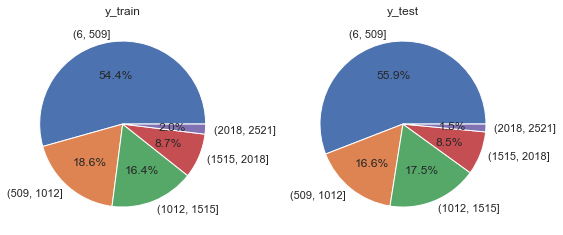

In [11]:
y_max = max(y_train.max(), y_test.max())
y_min = min(y_train.min(), y_test.min())
min_max_range = list(range(y_min,y_max+1,(y_max-y_min)//5))

sns.set(style='whitegrid')
fig, ax = plt.subplots(1, 2, figsize=(8,4))

for i, (name, y) in enumerate({'y_train':y_train,'y_test':y_test}.items()):

    cutted_counts = pd.cut(y.flatten(),bins=min_max_range).value_counts()
    ax[i].pie(cutted_counts, labels=cutted_counts.index, autopct='%.1f%%')
    ax[i].set(title=name)

plt.tight_layout()
plt.show()

### Feature Normalization
수치형 열과 범주형 열을 각각 구분해 Standard Scaling 및 One Hot Encoding을 진행했습니다.

In [13]:
numerical_transformer = StandardScaler()
numerical_features = ['Age','Days_Customer','Income','Income_Level','Income_Per',
                        'NumAcceptedCmp','NumPurchases','Recency']

categorical_transformer = OneHotEncoder(categories='auto', handle_unknown='ignore')
categorical_features = ['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5',
                        'Age_Range','Complain','Education','Kidhome','Marital_Status',
                        'NumCatalogPurchases','NumDealsPurchases','NumStorePurchases',
                        'NumWebPurchases','NumWebVisitsMonth','Perferred_Purchase','Response','Teenhome']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

pipe = Pipeline(steps=[('preprocessor', preprocessor)])

train_label = np.array(train[['target']])
train_data = pipe.fit_transform(train.drop(['target'], axis=1))
test_data = pipe.transform(test)

x_train = pipe.transform(x_train)
x_test = pipe.transform(x_test)

In [14]:
print(train_data.shape, test_data.shape, train_label.shape)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(1102, 115) (1108, 115) (1102, 1)
(771, 115) (331, 115) (771, 1) (331, 1)
